# Quantization In‑Depth – Part2

Hands‑on notebook exploring **symmetric linear quantization**, the impact of **quantization granularity** (per‑tensor, per‑channel, per‑group) and how to run **inference with quantized layers**. Examples rely on PyTorch 2.1 and the helper utilities supplied with the course.

## 0. Set-up and imports
Run the next cell to install and import the libraries used throughout the notebook.

ℹ️ *Skip the installation step if PyTorch is already available in your environment.*

In [1]:
#!pip install --quiet torch==2.1.1 seaborn matplotlib
import torch, seaborn as sns, matplotlib.pyplot as plt, math
from helper import (
    quantization_error,
    linear_q_with_scale_and_zero_point,
    linear_dequantization,
    plot_quantization_errors,
)
print('PyTorch version:', torch.__version__)

PyTorch version: 2.1.1+cu121


## 1. Symmetric vs. Asymmetric Linear Quantization

In **asymmetric** quantization we map the floating-point range  
$[r_{\min},\, r_{\max}]$ to the integer range $[q_{\min},\, q_{\max}]$ and  
store a *zero-point* $z$ so that $r = 0$ can be represented exactly.

In **symmetric** quantization we constrain the ranges to be centred at zero:

$$
r_{\min} = -r_{\max}, \qquad q_{\min} = -q_{\max}
$$

This removes the need for a zero-point and simplifies the forward and backward path:

$$
q = \mathrm{round}\!\left(\frac{r}{s}\right), \qquad r \approx s\,q
$$

with a single scale parameter

$$
s = \frac{r_{\max}}{q_{\max}}
$$

Besides the conceptual neatness, the absence of a zero-point reduces memory footprint and can unlock more efficient integer kernels on some hardware.


In [2]:
def get_q_scale_symmetric(tensor: torch.Tensor, dtype=torch.int8):
    """Return the scale for symmetric quantization of *tensor*."""
    r_max = tensor.abs().max().item()
    q_max = torch.iinfo(dtype).max
    return r_max / q_max

def linear_q_symmetric(tensor: torch.Tensor, dtype=torch.int8):
    """Symmetric 8‑bit linear quantization (per‑tensor)."""
    scale = get_q_scale_symmetric(tensor, dtype)
    q = linear_q_with_scale_and_zero_point(tensor, scale=scale, zero_point=0, dtype=dtype)
    return q, scale

### Quick demonstration

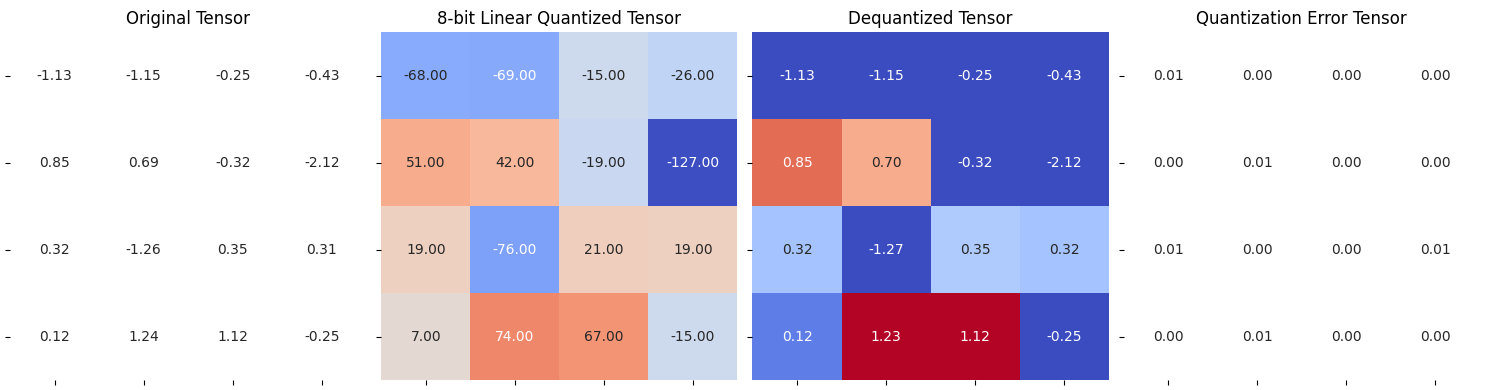

Scale: 0.016655270508893833
Mean‑squared quantization error: 1.6701500499038957e-05


In [3]:
# Symmetric quantization of a random 4×4 tensor
torch.manual_seed(0)
test_tensor = torch.randn(4,4)
q_tensor, scale = linear_q_symmetric(test_tensor)
dq_tensor = linear_dequantization(q_tensor, scale, 0)
plot_quantization_errors(test_tensor, q_tensor, dq_tensor)
print('Scale:', scale)
print('Mean‑squared quantization error:', quantization_error(test_tensor, dq_tensor).item())

**Trade‑offs.**
* *Dynamic range utilisation* – Asymmetric quantization always uses the full integer range. If the floating‑point distribution is heavily biased (e.g. ReLU activations that never go below zero), symmetric quantization wastes half of the representable values.
* *Simplicity* – The arithmetic path is simpler (no subtraction of `z`) and the parameters require one scalar less.
* *Common practice* – 8‑bit quantization of weights typically uses symmetric mode, while very low bit‑widths (2‑4 bits) often adopt asymmetric mode to squeeze out each bit.

## 2. Quantization Granularity
The scale (and zero‑point) can be shared across different subsets of the tensor:

| Granularity | Parameters | Pros | Cons |
|-------------|------------|------|------|
| **Per‑tensor** | 1 scale | Minimal memory | Highest error |
| **Per‑channel** | scales = #channels | Good balance | Slightly more memory |
| **Per‑group** | scales = #groups | Best accuracy | Extra bookkeeping, irregular memory layout |

The course explores each option in code.

### 2.1 Per‑tensor (single scale)

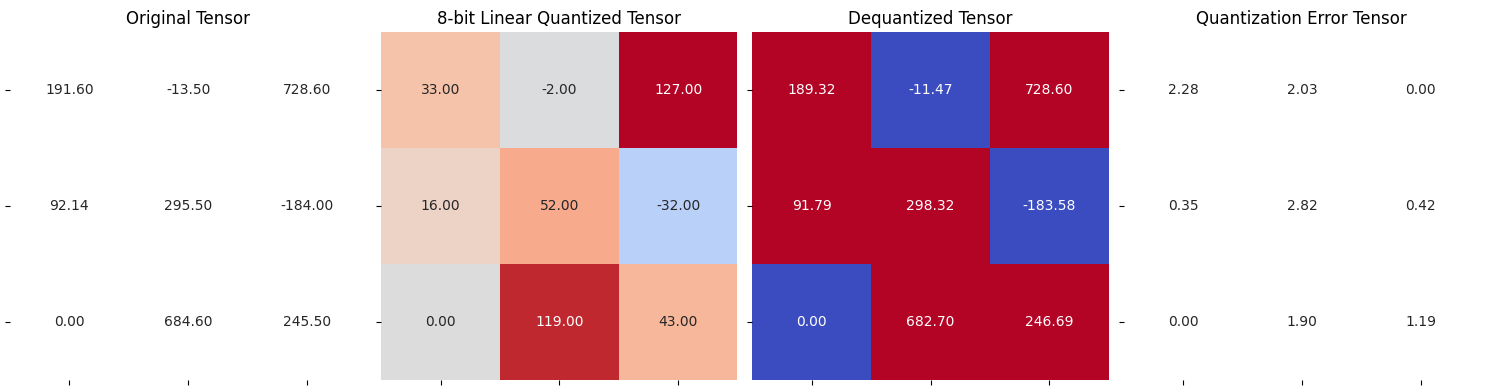

Mean‑squared error: 2.5091912746429443


In [4]:
test_tensor = torch.tensor([
    [191.6, -13.5, 728.6],
    [ 92.14, 295.5, -184.0],
    [  0.0, 684.6, 245.5]
])
q_t, s_t = linear_q_symmetric(test_tensor)
dq_t = linear_dequantization(q_t, s_t, 0)
plot_quantization_errors(test_tensor, q_t, dq_t)
print('Mean‑squared error:', quantization_error(test_tensor, dq_t).item())

### 2.2 Per‑channel (axis‑wise)

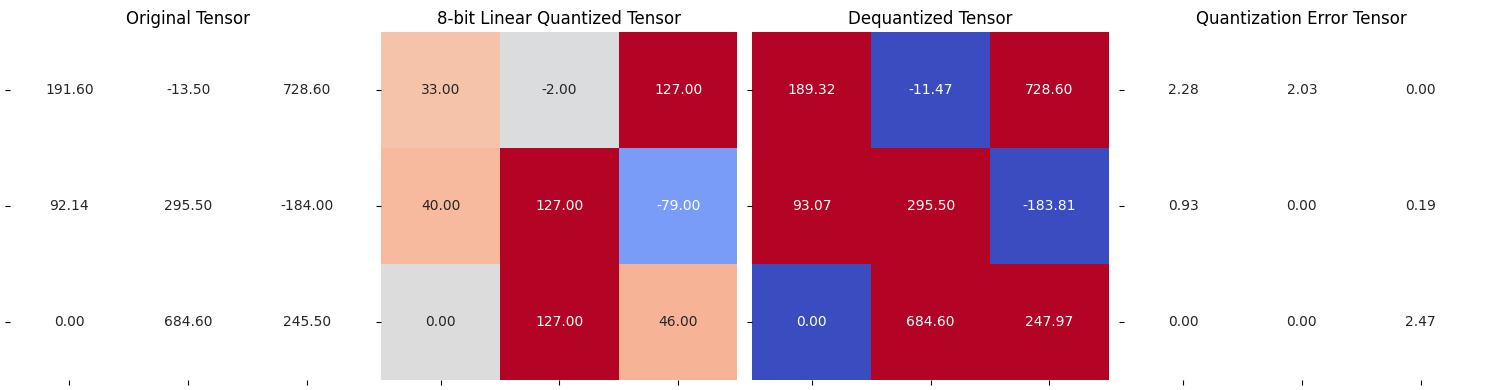

Row‑wise MSE: 1.8084441423416138


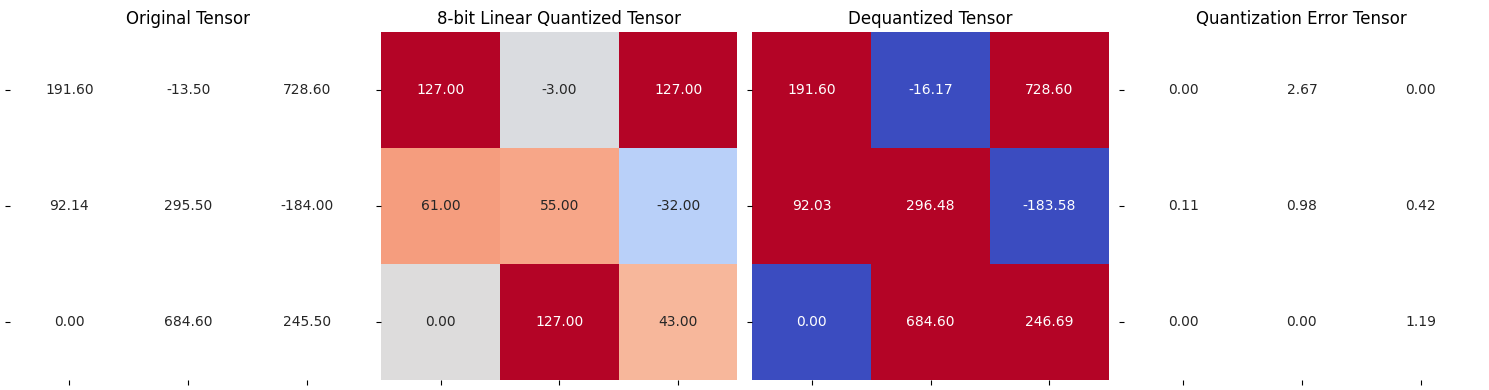

Column‑wise MSE: 1.0781488418579102


In [5]:
def linear_q_symmetric_per_channel(r_tensor: torch.Tensor, dim: int, dtype=torch.int8):
    """Symmetric quantization with an independent scale per *dim*."""
    output_dim = r_tensor.shape[dim]
    # Initialize scales for each channel
    scales = torch.zeros(output_dim)
    # Compute scale for each channel
    for i in range(output_dim):
        sub = r_tensor.select(dim, i)
        scales[i] = get_q_scale_symmetric(sub, dtype)
    # Reshape for broadcasting
    shape = [1]*r_tensor.dim(); shape[dim] = -1
    scales = scales.view(shape)
    q = linear_q_with_scale_and_zero_point(r_tensor, scale=scales, zero_point=0, dtype=dtype)
    return q, scales

# Along rows (dim=0)
q_row, s_row = linear_q_symmetric_per_channel(test_tensor, dim=0)
dq_row = linear_dequantization(q_row, s_row, 0)
plot_quantization_errors(test_tensor, q_row, dq_row)
print('Row‑wise MSE:', quantization_error(test_tensor, dq_row).item())

# Along columns (dim=1)
q_col, s_col = linear_q_symmetric_per_channel(test_tensor, dim=1)
dq_col = linear_dequantization(q_col, s_col, 0)
plot_quantization_errors(test_tensor, q_col, dq_col)
print('Column‑wise MSE:', quantization_error(test_tensor, dq_col).item())

### 2.3 Per‑group

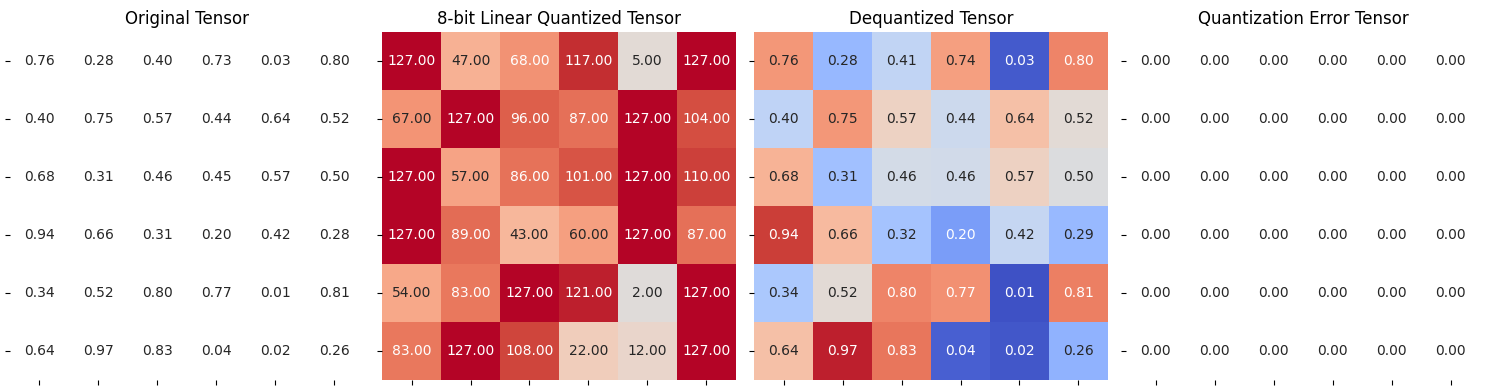

Group‑quant MSE: 1.8404656429993338e-06


In [6]:
def linear_q_symmetric_per_group(tensor: torch.Tensor, group_size: int, dtype=torch.int8):
    """Symmetric quantization with an independent scale per group."""
    # Reshape tensor into groups, need to assert cols are multiple of group_size
    assert tensor.dim()==2 and tensor.shape[1] % group_size == 0, 'Expect 2‑D tensor with cols multiple of group_size'
    # Reshape tensor into groups
    t_view = tensor.view(-1, group_size)
    # Quantize each group
    q, scales = linear_q_symmetric_per_channel(t_view, dim=0, dtype=dtype)
    return q.view_as(tensor), scales  # scales has one entry per group

def linear_dequantization_per_group(q_tensor: torch.Tensor, scales: torch.Tensor, group_size: int):
    """Dequantization with an independent scale per group."""
    # Reshape tensor into groups    
    q_view = q_tensor.view(-1, group_size)
    # Dequantize each group 
    dq = linear_dequantization(q_view, scales, 0)
    # Reshape back to original shape
    return dq.view_as(q_tensor)

torch.manual_seed(1)
t2 = torch.rand(6,6)
group_size = 3
q_g, s_g = linear_q_symmetric_per_group(t2, group_size)
dq_g = linear_dequantization_per_group(q_g, s_g, group_size)
plot_quantization_errors(t2, q_g, dq_g)
print('Group‑quant MSE:', quantization_error(t2, dq_g).item())

*Memory footprint example – 4‑bit per‑group (group_size = 32)*
* **Data:** 4 bits × 32 = 128 bits
* **Scale:** 16 bits (FP16)
→ effective **4.5 bits** per value, yet the error is usually orders of magnitude smaller than per‑tensor 4‑bit quantization.

## 3  Inference with Quantized Weights & Activations — Quick Recap  

**Notation.**  *W*-bits refer to weight precision, *A*-bits to activation precision (e.g. **W8A32** = 8-bit weights, 32-bit activations).  

* **Why quantise weights?**  ➜ ≈4× smaller model, faster memory traffic.  
* **Why keep activations FP32?**  ➜ zero accuracy loss and you can reuse the standard FP32 GEMM kernel.  
* **Key step:** on-the-fly de-quantisation  
  $$
  W_{\text{FP32}} \; \approx \; s_W \;\bigl(W_{\text{INT8}} - z_W\bigr)
  $$
  which can be fused with the matrix multiply.

---

#### Choosing W8A32 or W8A8  

| Variant | Arithmetic Path | Pros | Cons |
|---------|-----------------|------|------|
| **W8A32** | *Quantise-once* weights → **multiply by scale → FP32 GEMM** | *Drop-in*: minimal code changes, no extra activation error | ~1.25× more memory bandwidth than full INT8 |
| **W8A8**  | **INT8·INT8 → INT32** dot products, optional FP32 cast | Highest speed on INT8-capable hardware, full INT memory savings | Requires runtime activation quantisation $$q_a=\text{round}\!\bigl(a/s_a\bigr)+z_a$$ and careful calibration/QAT |

**Rule of thumb:** start with **W8A32** for an easy win; switch to **W8A8** only when target CPU/GPU/NPU offers efficient INT8 dot-product units and are ready for calibration or quantisation-aware training.


In [7]:
def quantized_linear_W8A32_without_bias(x: torch.Tensor, q_w: torch.Tensor, s_w: float, z_w: int=0):
    """
    Compute the output of a linear layer with quantized weights.
    """ 
    # Validate input types
    assert x.dtype == torch.float32 and q_w.dtype == torch.int8
    # Dequantize weights on-the-fly
    w = q_w.float() * s_w + z_w  
    # Compute the output
    return torch.nn.functional.linear(x, w)

input_vec = torch.tensor([1,2,3], dtype=torch.float32)
weight = torch.tensor([
    [-2.0,  -1.13, 0.42],
    [-1.51, 0.25, 1.62],
    [0.23,  1.35, 2.15]
], dtype=torch.float32)

q_w, s_w = linear_q_symmetric(weight)
out_q = quantized_linear_W8A32_without_bias(input_vec, q_w, s_w)
out_fp = torch.nn.functional.linear(input_vec, weight)
print('Quantized output:', out_q)
print('FP32 output     :', out_fp)
print('Max absolute error:', (out_q - out_fp).abs().max().item())

Quantized output: tensor([-2.9965,  3.8768,  9.3957])
FP32 output     : tensor([-3.0000,  3.8500,  9.3800])
Max absolute error: 0.02677178382873535


## 4. Take‑aways
* Symmetric quantization trades a small dynamic‑range penalty for simpler math and lower memory.
* Increasing granularity (channel / group) systematically reduces error at the cost of extra scales.
* Dequantizing weights on‑the‑fly keeps the forward pass simple (**W8A32**), while hardware with INT8 dot‑product units can run fully integer (**W8A8**).

*Recommended to try experimenting with lower bit‑widths, larger tensors or activation quantization to deepen understanding.*